### Описание проекта

Есть данные сервиса по продаже билетов на развлекательные мероприятия:

- лог сервера с данными о посещениях
- выгрузка всех заказов за период
- статистика рекламных расходов

Нужно понять:

- как люди пользуются продуктом
- когда они начинают покупать
- сколько денег приносит каждый клиент
- когда клиент окупается

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [81]:
sns.set(
    font_scale=1,
    style="white",
    rc={'figure.figsize':(12,6)}
        )

### Загрузим данные и приготовим их к анализу

In [82]:
visits_log = pd.read_csv('visits_log_us.csv')
orders_log= pd.read_csv('orders_log_us.csv')
costs = pd.read_csv('costs_us.csv')

#### Изучим данные. Внешний вид, формат и объем

In [83]:
visits_log.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [85]:
visits_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [86]:
orders_log.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [87]:
orders_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [88]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [89]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [91]:
visits_log.shape, orders_log.shape, costs.shape

((359400, 5), (50415, 3), (2542, 3))

#### Откорректируем название столбцов и тип данных

In [92]:
def replace_col_names(data):
    data.columns = [col.lower().replace(' ', '_') for col in data.columns] 
    return data

In [167]:
# переименнуем колонки
visits = replace_col_names(visits_log)
orders = replace_col_names(orders_log)

# приведем даты к соотвествующему типу
visits['end_ts'], visits['start_ts'] = pd.to_datetime(visits['end_ts']), pd.to_datetime(visits['start_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

In [168]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

### Построим отчеты и посчитаем метрики

### 1. Продукт

#### Сколько людей пользуются продуктом каждый день, неделю и месяц?

In [96]:
dau_mean = visits.groupby(visits['start_ts'].dt.date).agg({'uid': 'nunique'}).mean().round()
wau_mean = visits.groupby(visits['start_ts'].dt.isocalendar().week).agg({'uid': 'nunique'}).mean().round()
mau_mean = visits.groupby(visits['start_ts'].dt.month).agg({'uid': 'nunique'}).mean().round()

In [97]:
print('Средний DAU: ', dau_mean['uid'])
print('Средний WAU: ', wau_mean['uid'])
print('Средний MAU: ', mau_mean['uid'])

Средний DAU:  908.0
Средний WAU:  5825.0
Средний MAU:  23228.0


Интересно, что средние уникальных пользователях по разным периодам сильно отличаются. Вероятно, такой перепад между DAU и MAU означает, что продукт живет за счет притока новых пользователей, а старые пользователи быстро отваливаются. Интересно будет дальше посмотреть на "липкость" и удержание.  

График DAU говорит, что количество пользователей каждый день колебалось от чуть менее 500 до 1500 с небольшими всплесками.

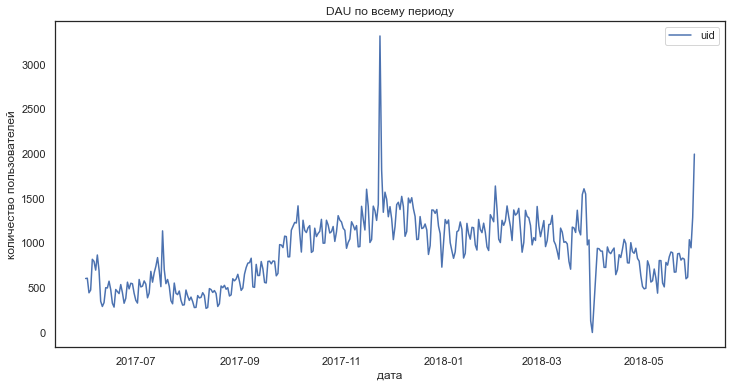

In [98]:
visits.groupby(visits['start_ts'].dt.date).agg({'uid': 'nunique'}).plot()
plt.xlabel('дата')
plt.ylabel('количество пользователей')
plt.title('DAU по всему периоду');

#### Сколько бывает сессий в день?

In [110]:
sessions_day = round(visits.groupby(visits['start_ts'].dt.date)['uid'].count().mean(), 0)
session_per_user = round(visits.groupby('uid')['start_ts'].count().mean(), 1)
print('Cредние количество сессий в день:', sessions_day)
print('В среднем у пользователей бывает {} сессии'.format(session_per_user))

Cредние количество сессий в день: 987.0
В среднем у пользователей бывает 1.6 сессии


Такое среднее число сессий означает, что как правило пользователи не пользуются сервисом больше одного раза.

Чаще всего пользователь проводит 60 секунд на сайте


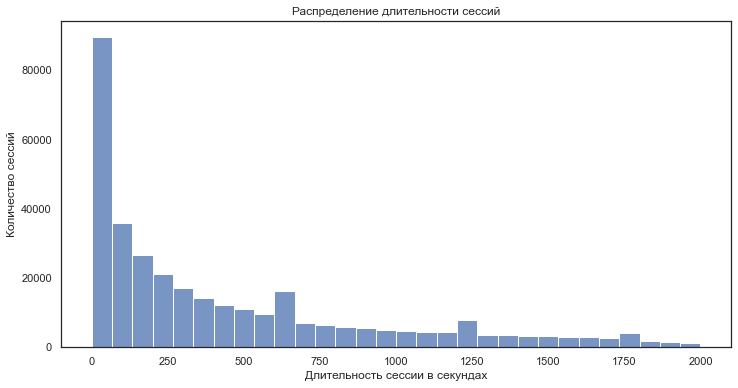

In [117]:
duration_session = (visits['end_ts'] - visits['start_ts']).dt.seconds
sns.histplot(data= duration_session, binrange=[0, 2000], bins=30)
plt.xlabel('Длительность сессии в секундах')
plt.ylabel('Количество сессий')
plt.title('Распределение длительности сессий')

print('Чаще всего пользователь проводит {} секунд на сайте'.format(duration_session.mode()[0]));

#### Как часто пользователи возвращаются?

In [121]:
sticky_factor_daily = dau_mean / wau_mean * 100
sticky_factor_weekly = dau_mean / mau_mean * 100
print(str(round(sticky_factor_daily[0], 1)) + '% пользователей возвращались в среднем в течение недели')
print(str(round(sticky_factor_weekly[0], 1)) + '%  пользователей возвращались в среднем в течение месяца')

15.6% пользователей возвращались в среднем в течение недели
3.9%  пользователей возвращались в среднем в течение месяца


Судя по sticky factor у пользователей довольно низкая вовлеченность в проект. Посчитаем retention по когортам, чтобы понять как ведут себя отдельные когорты пользователей.

In [169]:
first_activity_date = visits.groupby('uid')['start_ts'].min() \
                           .rename('first_activity_date')                            
visits = visits.join(first_activity_date, on="uid" )

In [170]:
visits['activity_month'] = visits['start_ts'].astype('datetime64[M]')
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')
visits['lifetime'] = (visits['activity_month'] - visits['first_activity_month']) / np.timedelta64(1, 'M')
visits['lifetime'] = visits['lifetime'].round().astype('int')

Разделим активность пользователей в конкретный месяц из каждой когорты на активность всех пользователей за весь период из этой же когорты

In [171]:
retention = visits.groupby(['first_activity_month', 'lifetime'])['uid'].nunique() \
                                                            / visits.groupby(['first_activity_month'])['uid'].nunique() * 100 
retention = retention.round(1).rename('retention')                                                          
visits = visits.join(retention, on=['first_activity_month', 'lifetime'])

Оформим в форме таблица

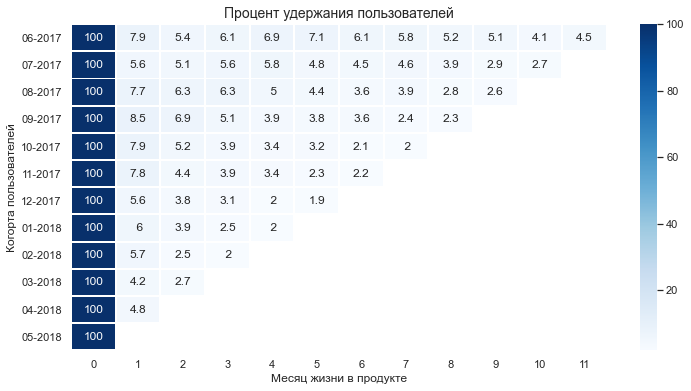

In [172]:
retention_pivot = visits.pivot_table(index='first_activity_month', columns='lifetime', values='retention')
retention_pivot.index = retention_pivot.index.strftime('%m-%Y')
sns.heatmap(retention_pivot, annot=True, fmt='2g', linewidths=1, cmap= 'Blues');
plt.title('Процент удержания пользователей', size=14)
plt.ylabel('Когорта пользователей')
plt.xlabel('Месяц жизни в продукте');

Retention 1 месяца на уровне 5-8%. Это низкий показатель, больше 90% пользователей отваливаютсяв в первый месяц. Возможно, люди редко ходят на развлекательные мероприятия. А может что-то не так с самим сервисом и он неудобен для пользователей. Необходимо сравнить с другими сервисами в этой области. Зато дальше все стабильно в рамках когорты. При этом, чем моложе когорта, тем лучше ретеншен. Возможно, это работает эффект новизны.

### 2. Продажи 

#### Когда люди начинают покупать?

In [173]:
first_order = orders.groupby(['uid'])['buy_ts'].min().rename('first_buy_date').astype('datetime64[ns]')
visits = visits.join(first_order, on='uid')

In [174]:
# Расчитаем сколько дней прошло от первого использования сайта до первой покупки
visits['conversion_day'] = ((visits['first_buy_date'] - visits['first_activity_date']) / np.timedelta64(1, 'D')).apply(np.ceil)

первая покупка происходит обычно в 1.0 день


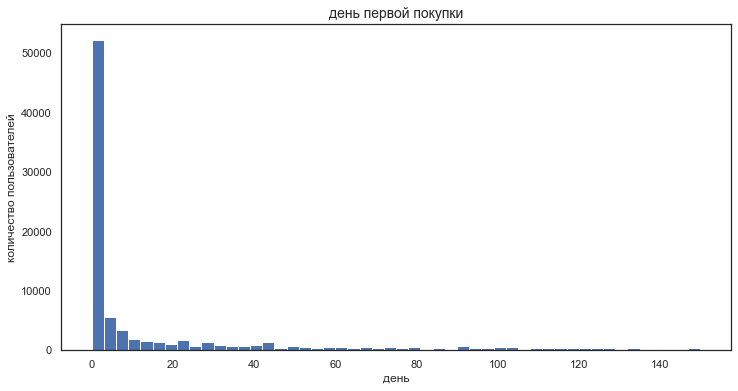

In [175]:
visits['conversion_day'].plot(kind = 'hist', bins=50, range=(0, 150))
plt.xlabel('день')
plt.ylabel('количество пользователей')
plt.title('день первой покупки', size=14)
print('первая покупка происходит обычно в {} день'.format(visits['conversion_day'].mode()[0]));

#### Сколько клиенты обычно делают покупок за период?

In [176]:
orders['buy_month'] = orders['buy_ts'].dt.date.astype('datetime64[M]')
orders['day'] = orders['buy_ts'].dt.date
orders['week'] = orders['buy_ts'].dt.isocalendar().week
orders['month'] = orders['buy_ts'].dt.month
orders['year'] = orders['buy_ts'].dt.year

In [135]:
print('Среднее количество покупок на клиента =', round(orders.groupby('uid')['revenue'].count().mean(), 2))
print('Клиенты совершают {} покупоки в день'.format(round(orders.groupby(['uid', 'day'])['revenue'].count().mean(), 2)))
print('Клиенты совершают {} покупоки в неделю'.format(round(orders.groupby(['uid', 'week'])['revenue'].count().mean(), 2)))
print('Клиенты совершают {} покупоки в месяц'.format(round(orders.groupby(['uid', 'month'])['revenue'].count().mean(), 2)))
print('Клиенты совершают {} покупоки в год'.format(round(orders.groupby(['uid', 'year'])['revenue'].count().mean(), 2)))

Среднее количество покупок на клиента = 1.38
Клиенты совершают 1.08 покупоки в день
Клиенты совершают 1.16 покупоки в неделю
Клиенты совершают 1.23 покупоки в месяц
Клиенты совершают 1.32 покупоки в год


Клиенты похоже редко делают больше одной покупки за период. Посмотрим по когортам.

In [177]:
first_activity_month = visits[['uid', 'first_activity_month']].drop_duplicates()
orders = orders.merge(first_activity_month, on='uid', how='inner')
orders['lifetime_buy'] = ((orders['buy_month'] - orders['first_activity_month']) / np.timedelta64(1, 'M')).round()
orders['lifetime_buy'] = orders['lifetime_buy'].round().astype('int')

In [180]:
grouped_for_cohorts = orders \
    .groupby(['first_activity_month', 'lifetime_buy'])['uid'] \
    .agg(['count', 'nunique']) \
    .reset_index() \
    .rename(columns = {'count': 'n_orders','nunique': 'n_users'})

grouped_for_cohorts['orders_per_users'] = round(grouped_for_cohorts['n_orders'] / grouped_for_cohorts['n_users'], 1)

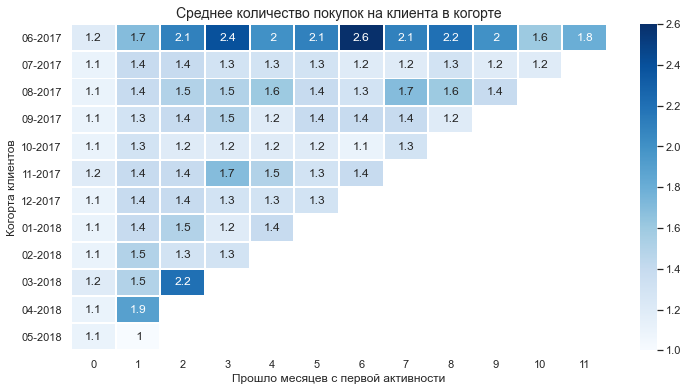

In [234]:
orders_per_users_pivot = grouped_for_cohorts.pivot_table(index='first_activity_month', columns='lifetime_buy', values='orders_per_users', aggfunc='mean')
orders_per_users_pivot.index = orders_per_users_pivot.index.strftime('%m-%Y')
sns.heatmap(orders_per_users_pivot, annot=True, fmt='2g', linewidths=1, cmap= 'Blues');
plt.title('Среднее количество покупок на клиента в когорте', size=14)
plt.ylabel('Когорта клиентов')
plt.xlabel('Прошло месяцев с первой активности');

Видно, что в первой когорте больше всего среднее количество покупок. Это наиболее лояльная когорота клиентов. Также заметен рост покупок в когортах 03-2018 и 04-2018. Далее посмотрим на динамику покупок за весь период.

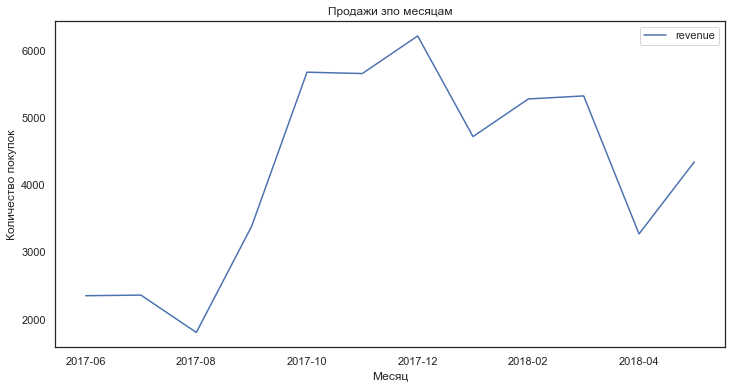

In [208]:
n_orders = orders.groupby('buy_month')['revenue'].count()[:-1]
n_orders = n_orders.reset_index()
n_orders = n_orders.set_index('buy_month')
n_orders.index = n_orders.index.strftime('%Y-%m')
n_orders.plot()
plt.ylabel('Количество покупок')
plt.xlabel('Месяц')
plt.title('Продажи зпо месяцам');

Больше всего покупок приходится на осеннне-зимний период. Виден пик в декабре, возможно, это связано с праздниками, в котороые людяи ходят чаще на развлекательные мероприятия.

#### Какой средний чек?

In [164]:
print('Средний чек равен {}$'.format(round(orders['revenue'].mean(),1)))

Средний чек равен 5.0$


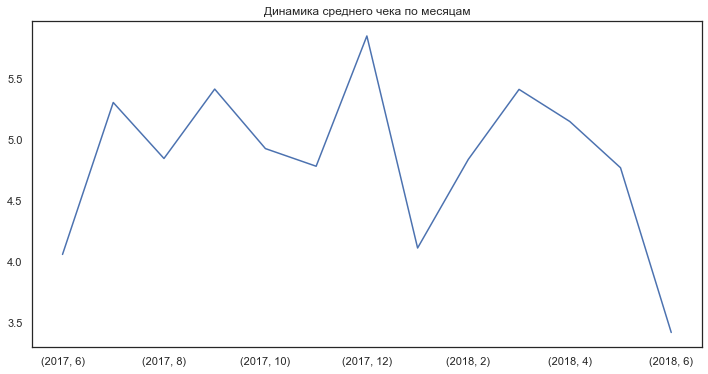

In [148]:
orders.groupby(['year','month'])['revenue'].mean().plot()
plt.title('Динамика среднего чека по месяцам')
plt.xlabel('');

Средний чек колебелется от 4 до 5,5 с пиком в декабря. Думаю, что дело в праздниках. Чек падает в летние периоды. Еще есть резкий спад после новогодних прездников, возможно, люди временно ужали свои траты после праздника.

####  Сколько денег приносят? (LTV)

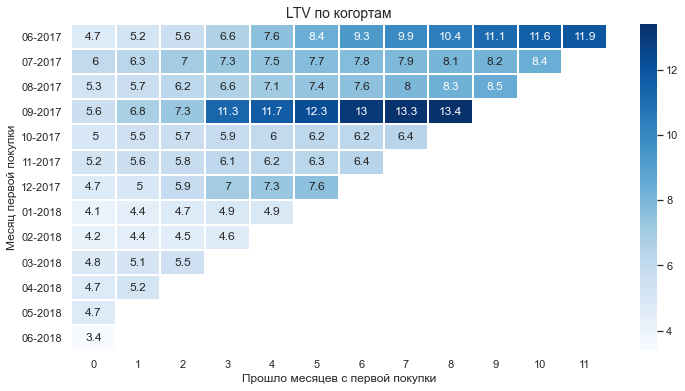

In [198]:
ltv_per_cohort = orders.groupby(['first_buy_month', 'month_cohort']).agg({'revenue': 'sum'}).reset_index() 
cohort_size = orders.groupby(['first_buy_month'])['uid'].nunique().rename('cohort_size')
ltv_per_cohort = ltv_per_cohort.join(cohort_size, on='first_buy_month')

ltv_per_cohort['ltv'] = ltv_per_cohort['revenue'] / ltv_per_cohort['cohort_size']

ltv_pivot = ltv_per_cohort.pivot_table(index='first_buy_month', columns='month_cohort', values='ltv')
ltv_pivot = ltv_pivot.cumsum(axis = 1).round(1)


ltv_pivot.index = ltv_pivot.index.strftime('%m-%Y')

sns.heatmap(ltv_pivot, annot=True, fmt='2g', linewidths=1, cmap= 'Blues');
plt.title('LTV по когортам', size=14)
plt.ylabel('Месяц первой покупки')
plt.xlabel('Прошло месяцев с первой покупки');

У нас есть двер когорты, в которых наибольшее ltv: 06-2017 и 09-2017. Эти пользователи приносят нам наибольший доход.


### 3. Маркетинг

#### Сколько денег потратили?

In [219]:
print('Всего потрачего на продвижение',costs['costs'].sum())
print('При этом выручка составила    ', round(orders['revenue'].sum(), 2))

Всего потрачего на продвижение 329131.62
При этом выручка составила     252057.2


Видно, что за анализируемый период сервис находится в убытке. Рассмотрим потробнее затраты по источникам

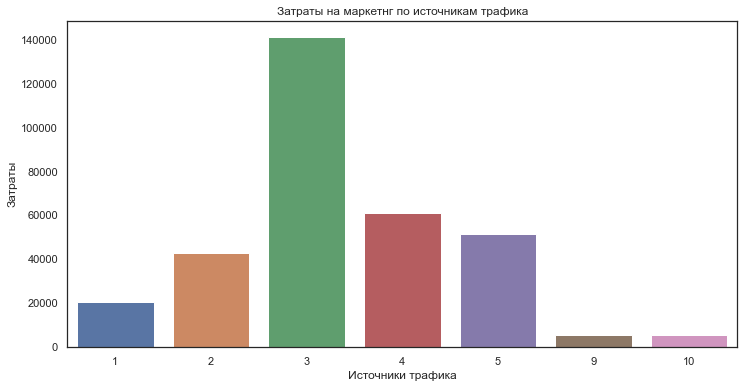

In [210]:
costs_per_source = costs.groupby('source_id')['costs'].sum().reset_index()
sns.barplot(x="source_id", y="costs", data=costs_per_source)
plt.xlabel('Источники трафика')
plt.ylabel('Затраты')
plt.title('Затраты на маркетнг по источникам трафика');

Больше всего было затрат на 3 источник

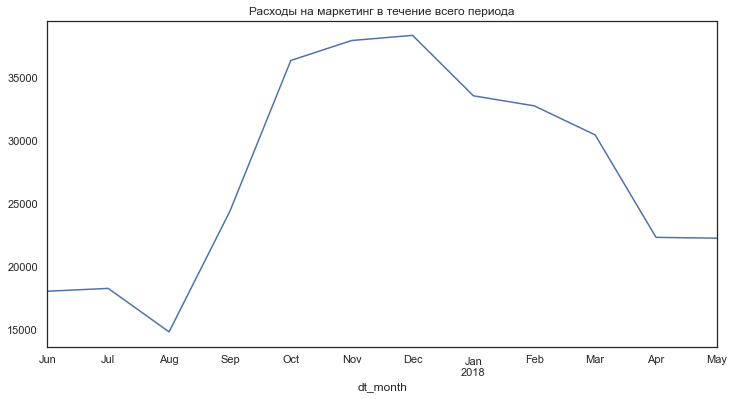

In [201]:
costs['dt_month'] = costs['dt'].astype('datetime64[M]')
costs_by_months = costs.groupby(['dt_month'])['costs'].sum()
costs_by_months.plot()
plt.title('Расходы на маркетинг в течение всего периода');

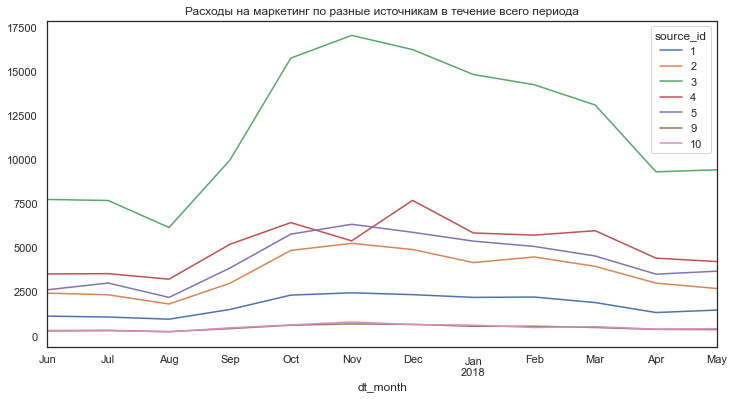

In [207]:
sources_costs_by_month = costs.pivot_table(index='dt_month', columns='source_id', values='costs', aggfunc='sum')
sources_costs_by_month.plot()
plt.title('Расходы на маркетинг по разные источникам в течение всего периода');

По графику видно, что расходы растут в осенне-зимний период. При этом более всего в этом период они растут по 3 источнику. Есть еще группа источников, которая по тратам находится примерно в диапозоне от 2500 до 7500. И группа из двух источников, где траты еще меньше. 

#### Сколько стоило привлечение одного покупателя из каждого источника?

In [ ]:
buyers_per_source = orders.merge(visits, on='uid')
buyers_per_source = buyers_per_source.groupby(['source_id']).agg({'uid':'nunique'}).reset_index()
buyers_per_source.rename(columns = {'uid': 'n_buyers'}, inplace=True)
buyers_per_source

Эх( многое заново. Подумать, затраты на привлечение (CAC) - это отношение затрат на первый визит к колич пользователей или ко всем визитам с этого источника. Скорее первые визиты

In [212]:
cac = costs_per_source.merge(buyers_per_source, on='source_id')
cac['cac'] = round(cac['costs'] / cac['n_buyers'],2)
cac.sort_values(by='cac', ascending=False)

,source_id,costs,n_buyers,cac
2,3,141321.63,13846,10.21
1,2,42806.04,7305,5.86
4,5,51757.10,10156,5.10
3,4,61073.60,14253,4.28
6,10,5822.49,1773,3.28
0,1,20833.27,7138,2.92
5,9,5517.49,2793,1.98


Самое дорогое привлечение в 3 источнике. И при этом на него больше всего расходуют средств. Может стоит вложиться в источники с меньше стоимость привлечения?

#### На сколько окупились расходы? (ROI)

#### ROI по источникам привлечение

Чтобы посчитать ROI по источникам, узнаем рекламные источники первых визитов. А затем посмотрим на выручку, который нам принесли клиенты, привлеченые этим источником. 

In [216]:
first_visit_source = visits.query('start_ts == first_activity_date')
orders = orders.merge(first_visit_source, on='uid', suffixes=('_z','')).drop(['first_activity_month_z'], axis=1)

In [220]:
revenue_per_source = orders.groupby(['source_id'])['revenue'].sum().reset_index()
revenue_per_source

,source_id,revenue
0,1,31090.55
1,2,46923.61
2,3,54511.24
3,4,56696.83
4,5,52624.02
5,7,1.22
6,9,5759.40
7,10,4450.33


Теперь посчитаем ROI от кажого источника. Указан в процентах.

In [228]:
roi = cac.merge(revenue_by_source, on='source_id')
roi['roi'] = (roi['revenue'] - roi['costs']) / roi['costs'] * 100
roi.sort_values('roi', ascending = False).round(2)

,source_id,costs,n_buyers,cac,revenue,roi
0,1,20833.27,7138,2.92,31090.55,49.24
1,2,42806.04,7305,5.86,46923.61,9.62
5,9,5517.49,2793,1.98,5759.40,4.38
4,5,51757.10,10156,5.10,52624.02,1.67
3,4,61073.60,14253,4.28,56696.83,-7.17
6,10,5822.49,1773,3.28,4450.33,-23.57
2,3,141321.63,13846,10.21,54511.24,-61.43


Итак, возврат инвестиций лучше всего источника 1. При этом возврат по 4, 10 и 3 источникам ушел в минус.

#### ROI по когортам

Для этого расчитаем ежемесячные затраты. Потом узнаем ежемесячный CAC по каждой когорте. И найдем roi по когортам, т.к. ltv и cac уже известны.

In [229]:
costs_per_month = costs.groupby('dt_month')['costs'].sum().reset_index()
costs_per_month.head()

,dt_month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88


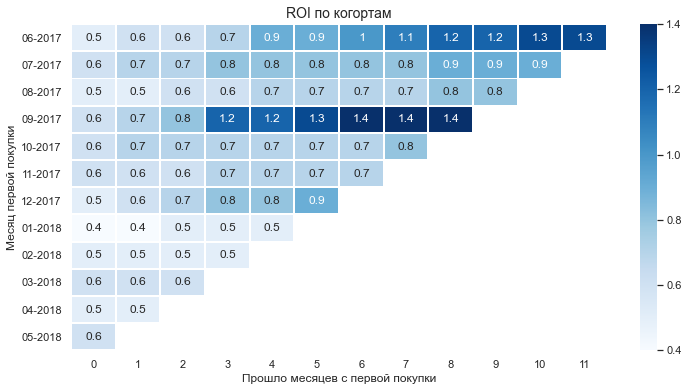

In [232]:
roi_per_cohort = ltv_per_cohort.merge(costs_per_month, left_on='first_buy_month', right_on='dt_month')
roi_per_cohort['cac'] =  roi_per_cohort['costs'] / roi_per_cohort['cohort_size']
roi_per_cohort['roi'] = roi_per_cohort['ltv'] / roi_per_cohort['cac']

roi_pivot = roi_per_cohort.pivot_table(index='first_buy_month', columns='month_cohort', values='roi')
roi_pivot = roi_pivot.cumsum(axis = 1).round(1)
roi_pivot.index = roi_pivot.index.strftime('%m-%Y')

sns.heatmap(roi_pivot, annot=True, fmt='2g', linewidths=1, cmap= 'Blues');
plt.title('ROI по когортам', size=14)
plt.ylabel('Месяц первой покупки')
plt.xlabel('Прошло месяцев с первой покупки');

Видно, что в когортах 06-2017 и 09-2017 возврат инвестиций выше, чем в остальных. Когорта 06-2017 окупилась на 6 месяц, а когорта 09-2017 уже на 3. Можно отметить, что когорты 07-2017 и 12-2017 тоже близки к оккупаемости (к roi=1). Остальные когорты окупаются медленнее, вероятно, из-за плохого удержания пользователей.

### 4. Выводы

Похоже сервисом пользуются редко. Об этом говорит ряд фактов. Обычно покупки совершается в первый день пользования сервисом. При этом длительность сессии не превыщает 60 секунд. Возможно, в сервисе не хватает инструментов удержания внимания пользователя. Кажется важным в будущем внедрить в сервис то, что помогло бы пользователям его обжить и больше проводить в нем времени. 

Проблемы с "интересностью" сервиса для пользователей отражаются на пользовательском поведении. Sticky factor 15,6% говорит нам о том, что сервис живет засчет притока новых пользователей, а не удержания старых. Значение retention около 7-8% в первый месяц жизни в продукте говорит, что сервис теряют большинство своих пользователей в первый месяц жизни в продукте. Дальше retention плавно снижается по мере старения когорт. Такой retention сразу влияет на прибыль сервиса, окупилось всего две когорты: roi больше 1 в самой первой когорте и в 09-2017. 

Когортыа 09-2017 вызывает интерес. Её roi и ltv хорошо выглядят на фоне остальных корот. Хорошо бы изучить причины успеха во взаиомдействие с ней. Возможно, есть что масштабировать на новых клиентов сервиса.

Кажется, маркетинг не очень эффективен. Больше всего денег тратиться на привлечение пользователей из источник 3. Хотя возврат инвестиций с него отрицательный. Думаю, что лучше вложить деньги в источник 4, который приносит больше всего покупателей, но при этом стоимость привлечения в нем в 2 раза меньше (4.28 vs 10.21). Источник 5 также выглядит перспективно. 